##### NB
- You might need to run `pip install tensorflow-addons` ´to use  `f1_score`.

# Compulsory Assignment 2: Convolutional neural networks

Please fill out the the group name, number, members and optionally the name below.

**Group number**: 30   
**Group member 1**: Peder Ørmen Bukaasen.   
**Group member 2**: Bård Tollef Pedersen.      
**Group member 3**: Eivind Lid Trøen.    
**Group name (optional)**: Dead Weights

Make sure that the group name given in the assignment is the same that you use on the Kaggle Leaderboard.

# Assignment Submission
To complete this assignment answer the relevant questions in this notebook and write the code required to implement the relevant models. The assignment is submitted by handing in this notebook as an .ipynb file and as a .pdf file. In addition, you are required to submit at least one test prediction to the Kaggle leaderboard that is better than the *BEAT ME* score.

NOTE: Remember to go through the rules given in the lecture "Introduction to compulsory assignments", as there are many do's and dont's with regard to how you should present the work you are going to submit.

# Introduction
This assignment will start with classifying handwritten digits from the MNIST dataset, used in the voluntary assignment and the first compulsory assignment. The second part of this task will revolve around classifying the open-source Fashion-MNIST dataset.



## Fashion-MNIST

The Fashion-MNIST is a dataset created from Zlalando's articile images(https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md). The dataset consits of 70,000 labels images in 28x28 grayscale image labeld from 0 to 10. The goal of the Fashion-MNIST to work as a harder version of the handletter dataset MNIST. The Github repo for the dataset descripte the dataset to be:
- "intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms."


<center><img src="fashion-mnist-sprite.png" width="500" height="400"></center>


## Assignment structure

1. Part 1: Implementing LeNet5 for classifying MNIST.
2. Part 2: Designing your own CNN for classifying Fashion-MNIST

## Submissions to the Kaggle leaderboard
Use the following code to create the `submission.csv` file that you can submit to the Kaggle leaderboard.

```python
prediction = model.predict(X_test)
flat_prediction = np.argmax(prediction, axis=1) # Flatten softmax predictions
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_prediction)) # The submission csv file must have an row index column called 'ID'
submissionDF['Prediction'] = flat_prediction
submissionDF.to_csv('submission.csv', index=False) # Remember to store the dataframe to csv without the nameless index column.
```

## Library imports

In [1]:
import time

import numpy as np
import pandas as pd
import h5py
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow.keras as ks
from tensorflow.keras import backend as K

SEED = 458
RNG = np.random.default_rng(SEED) # Random number generator

from utilities import *

# Part 1: CNN for classifying the MNIST dataset

## Loading MNIST

In [2]:
datasets = load_mnist(verbose=0)
X_train, y_train = datasets['X_train'], datasets['y_train']
X_val,   y_val   = datasets['X_val'],   datasets['y_val']
X_test,  y_test  = datasets['X_test'],  datasets['y_test']

X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val], axis=0).astype('int32')

del datasets, X_val, y_val # Good to reduce uneccesary RAM usage

11490434/11490434 [==============================] - 0s 0us/step


## Preprocessing

In [3]:
# Reshape data to account for color channel
X_train = np.expand_dims(X_train, -1)
X_test  = np.expand_dims(X_test, -1)

# Normalizing input between [0,1]
X_train = X_train.astype("float32")/np.max(X_train)
X_test  = X_test.astype("float32")/np.max(X_test)

# Converting targets from numbers to categorical format
y_train = ks.utils.to_categorical(y_train, len(np.unique(y_train)))
y_test  = ks.utils.to_categorical(y_test, len(np.unique(y_test)))

## Task 1.1: Build a CNN network with the LeNet5 architecture

##### Implement LeNent5 architecture according to the following specifications:

--------------------------
The LeNet architecture takes a 28x28xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

**Layer 1 - Convolution (5x5):** The output shape should be 28x28x6. **Activation:** ReLU.

**MaxPooling:** The output shape should be 14x14x6.

**Layer 2 - Convolution (5x5):** The output shape should be 10x10x16. **Activation:** ReLU.

**MaxPooling:** The output shape should be 5x5x16.

**Flatten:** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.  You may need to use tf.reshape.

**Layer 3 - Fully Connected:** This should have 120 outputs. **Activation:** ReLU.

**Layer 4 - Fully Connected:** This should have 84 outputs. **Activation:** ReLU.

**Layer 5 - Fully Connected:** This should have 10 outputs. **Activation:** softmax.

--------------------------


##### Compile the network with the
* `tf.keras.losses.CategoricalCrossentropy` loss function
* the `adam` optimizer
* with the `accuracy` metric and (your own implementation of the) F1-score metric.

In [4]:
model_LeNet5 = ks.models.Sequential(
    [   ks.layers.Conv2D(filters=6, kernel_size=[5,5], padding='same', activation='relu',
                 input_shape=(X_train.shape[1:])),
        ks.layers.MaxPooling2D(pool_size=[2,2], padding='same'),
        ks.layers.Conv2D(filters=16, kernel_size=[5,5], padding='valid', activation='relu'),
        ks.layers.MaxPooling2D(pool_size=[2,2], padding='same'),
        ks.layers.Flatten(),
        ks.layers.Dense(120, activation='relu'),
        ks.layers.Dense(84, activation='relu'),
        ks.layers.Dense(10, activation='softmax')
        ])

model_LeNet5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [5]:
# Create f1 score
def f1_score_(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return K.mean(f1)

In [6]:
opt = ks.optimizers.Adam(learning_rate=0.0001)
model_LeNet5.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_score_])

### Task 1.1.2 Train network

Train the network with a
* batch size of 64 samples
* for 20 epochs
* 1/8 validation split

In [7]:
train_LeNet5 = model_LeNet5.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=(1/8))

Epoch 1/20
821/821 [==============================] - 8s 9ms/step - loss: 0.8128 - accuracy: 0.7805 - f1_score_: 0.6340 - val_loss: 0.3014 - val_accuracy: 0.9097 - val_f1_score_: 0.9024
Epoch 2/20
821/821 [==============================] - 6s 8ms/step - loss: 0.2542 - accuracy: 0.9242 - f1_score_: 0.9146 - val_loss: 0.2093 - val_accuracy: 0.9395 - val_f1_score_: 0.9324
Epoch 3/20
821/821 [==============================] - 6s 8ms/step - loss: 0.1879 - accuracy: 0.9434 - f1_score_: 0.9360 - val_loss: 0.1620 - val_accuracy: 0.9524 - val_f1_score_: 0.9470
Epoch 4/20
821/821 [==============================] - 7s 8ms/step - loss: 0.1486 - accuracy: 0.9561 - f1_score_: 0.9484 - val_loss: 0.1358 - val_accuracy: 0.9600 - val_f1_score_: 0.9547
Epoch 5/20
821/821 [==============================] - 7s 8ms/step - loss: 0.1220 - accuracy: 0.9633 - f1_score_: 0.9591 - val_loss: 0.1168 - val_accuracy: 0.9644 - val_f1_score_: 0.9619
Epoch 6/20
821/821 [==============================] - 7s 8ms/step - lo

## Task 1.2 Evaluaiton
### Task 1.2.1 Plot training history and evaluate on test dataset

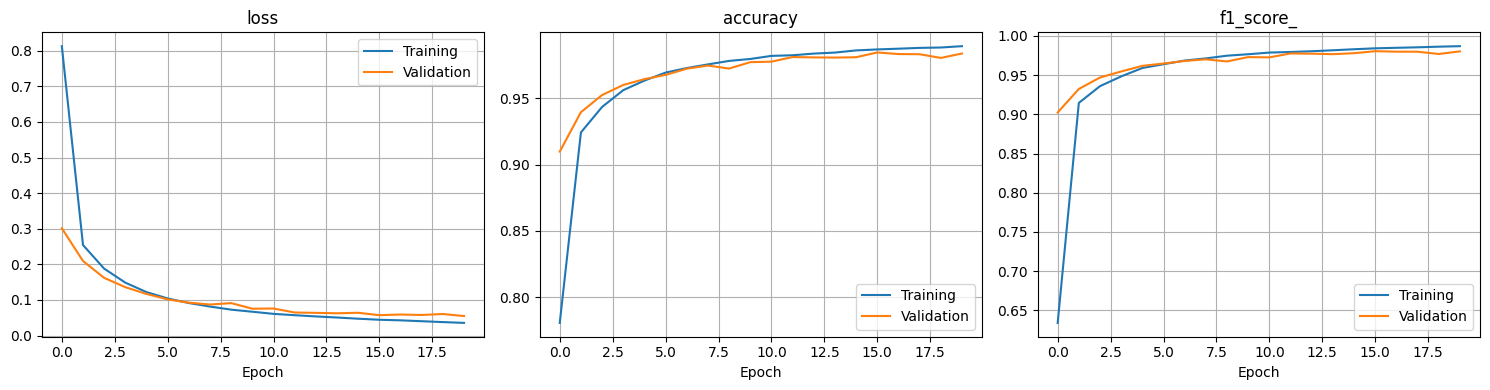

In [8]:
plot_training_history(train_LeNet5)

### Task 1.2.2 Evaluate on the test dataset

In [9]:
results_LeNet5 = model_LeNet5.evaluate(X_test, y_test)
print("test loss, test acc, test f1:", results_LeNet5)

313/313 [==============================] - 1s 4ms/step - loss: 0.0441 - accuracy: 0.9851 - f1_score_: 0.9581
test loss, test acc, test f1: [0.04410932585597038, 0.9850999712944031, 0.9581263661384583]


### Task 2.2.3 Create a confution matrix for both traing and testing data
- Does the test data and train data predikt the same items wrong?

313/313 [==============================] - 1s 4ms/step


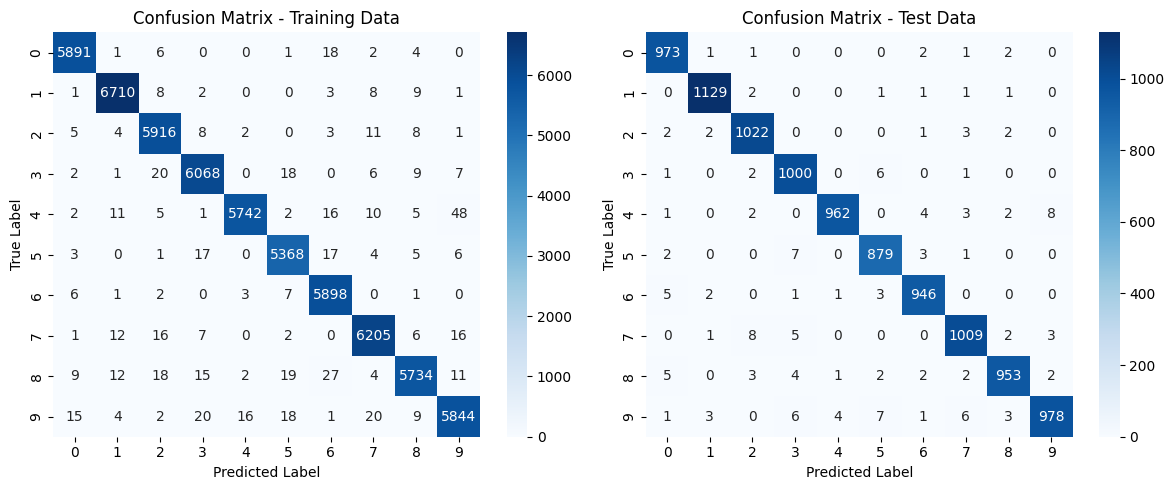

In [10]:
y_train_pred = np.argmax(model_LeNet5.predict(X_train), axis=1)
y_test_pred = np.argmax(model_LeNet5.predict(X_test), axis=1)
y_train_true = np.argmax(y_train, axis=1)
y_test_true = np.argmax(y_test, axis=1)

cm_train = confusion_matrix(y_train_true, y_train_pred)
cm_test = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()


We can see a that the confution matrix are similar in both plots, with the same missclassifications. Eksample is 7 predicted as 2.

## Task 2.3: MNIST discussion

**Task 2.3.1: What is overfititng and how does it ocure during training of the LeNet-5 model**

**Task 2.3.2: What is ReLU and Leaky ReLU, what is their derivative and how does their derative solve the vanesting gradient problem?**

**Task 2.3.3: Calculate the Number of Trainable Parameters and the Output Shape of Feature Maps for LeNet-5 at Each Layer**


**Task 2.3.1:** Overfitting is when a model learns the training data too well. It will then be less accurate for new data. Even though LeNet-5 is not as deep as modern networks, the fully connected layers at the end contain many parameters. This increases the risk of the model memorizing the training data rather than generalizing. LeNet-5 does not include regularization techniques like dropout or weight decay, making it more susceptible to overfittin. Here it looks like it overfitts around epoch 12

**Task 2.3.2:**  
**ReLU:**  
x if x>0,   
0 if x≤0.
This means that if a value is negativ it is 0, else it is the value.  
**Derivative of ReLU:**  
1 if x>0,   
0 if x≤0.

**Leaky ReLU:**   
x if x>0.   
αx if x≤0. (where α is a small value as 0.001).
This means that ig a vlues is negative it is multplied by a small number to keep the nuron "alive".  
**Derivative of Leaky ReLU:**  
1 if x>0,   
α if x≤0.

ReLU solves the vanishing gradient problem by having a graident as 1 or 0. This will keep the gradient at a high value and vanishing gradient vil never happen. Unlike the sigmoid where the gradient get smaller and smaller.
Leaky ReLU does the same as ReLU for positiv numbers, for negative numbers it will also have a constant wich prevent it from the vanishing gradient as well as prevent the nuron from becoming 0, and "dying".  
**Task 2.3.3:**  
For Output shape we use this formula:  
[(W−K+2P)/S]+1.  
W is the input volume.  
K is the Kernel size.  
P is the padding.  
S is the stride.
This give the height and width and the number of filters is the depth.

For trainable Parameters we use this formula for convelution:  
(k_w x k_h x C_in +1) x C_out
k_w is kernel width.  
k_h is kernel height.  
C_in is number of input channels.  
C_out is number of filters.  

For trainable Parameters we use this formula for fully connected layers:
input units x output units + output units

conv2d 0:   
Params = (5x5x1 + 1) x6 = 156.  
Feature Map = (28-5+2*2)/1 + 1 = (28, 28, 6)

max_pooling2d 0:  
Params = 0.  
Feature Map = (28-2+2*0)/2 + 1 = (14, 14, 6)

conv2d 1:     
Params = (5x5x6+1) x16 = 2416.  
Feature Map = (14-5+2*0)/1 + 1 = (10, 10, 16)

max_pooling2d 1:
Params = 0.  
Feature Map = (10-2+2*0)/2 + 1 = (5, 5, 16)

flatten:
Params = 0.
Feature Map = 5 x 5 x 16 = 400

dense:
Params = 400x120 + 120 = 48120.   
Feature Map = 120

dense_1:
Params = 120x84 + 84 = 10164.  
Feature Map = 84

dense_2:  
Params = 84x10 + 10 = 850.
Feature Map = 10

# Task 2: CNN for classifying the Fashion-MNIST dataset

In this task you shall implement a CNN model, and train it to classify the images in the Fashion-MNIST dataset.

## Importing Fashion-MNIST

- Filename: `Fashion_MNIST.h5`

In [11]:
FILE_PATH = "Fashion_MNIST.h5" # If data is in same directory as Jypyter File

labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [12]:
with h5py.File(FILE_PATH,'r') as f:
    print('Datasets in file:', list(f.keys()))
    X_train = np.asarray(f['train_images'])
    y_train = np.asarray(f['train_labels'])
    X_test  = np.asarray(f['test_images'])
    print('Nr. train images: %i'%(X_train.shape[0]))
    print('Nr. test images: %i'%(X_test.shape[0]))

Datasets in file: ['test_images', 'train_images', 'train_labels']
Nr. train images: 59500
Nr. test images: 10500


## Task 2.1: Preprocess the data
Preprocess the data as you see fit

In [13]:
# Reshape data to account for color channel
X_train = np.expand_dims(X_train, -1)
X_test  = np.expand_dims(X_test, -1)

# Normalizing input between [0,1]
X_train = X_train.astype("float32")/255
X_test  = X_test.astype("float32")/255

# Converting targets from numbers to categorical format
y_train = ks.utils.to_categorical(y_train, len(np.unique(y_train)))

In [14]:
# Add noise to random images,
# not in use as it made model worse
indices = np.random.choice(X_train.shape[0], y_train.shape[0]//6, replace=False)
selected_images = X_train[indices]
selected_labels = y_train[indices]

noisy_images = selected_images + 0.2 * np.random.randn(*selected_images.shape)
noisy_images = np.clip(noisy_images, 0.0, 1.0)

noise_X_train = np.concatenate([X_train, noisy_images], axis=0)
noise_y_train = np.concatenate([y_train, selected_labels], axis=0)

## Task 2.2: Visualize the dataset
Plot a few samples images and the distrbution of classes in the data.

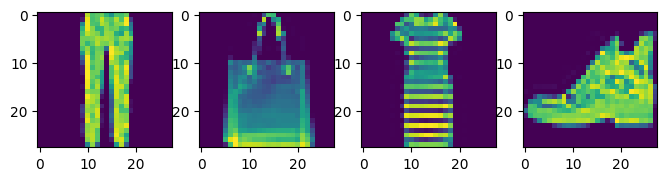

In [15]:
random_images = RNG.choice(X_train, replace=False, size=4)
fig, ax = plt.subplots(1,4,figsize=(8,8))
for i in range(random_images.shape[0]):
    ax[i].imshow(random_images[i])
plt.show()

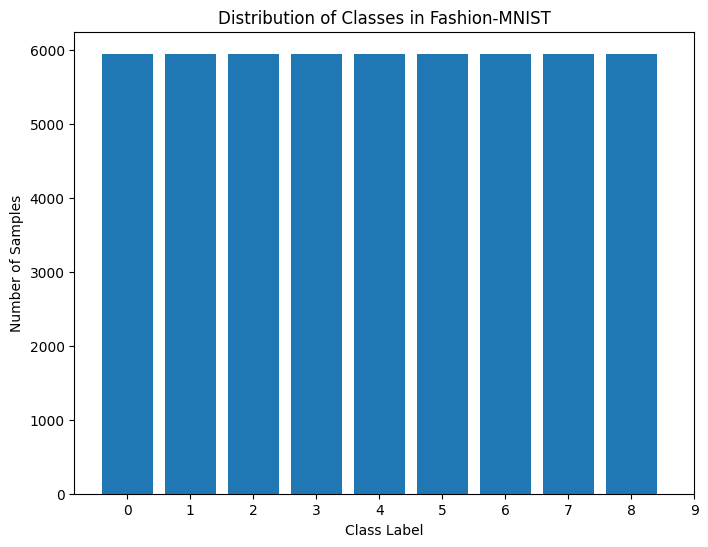

In [16]:
y_train_labels = np.argmax(y_train, axis=1)
plt.figure(figsize=(8, 6))
plt.hist(y_train_labels, bins=np.arange(10) - 0.5, align='mid', rwidth=0.8)
plt.xticks(np.arange(10))
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in Fashion-MNIST')
plt.show()


## Task 2.3: Build a CNN for Classifying the Fashion-MNIST Dataset
Build a CNN model and beat the "Beat Me" score on Kaggle.

- Experiment with different kernel sizes, strides, and types/number of layers.
- Don’t overcomplicate it; focues on as grounds for discussion when you make the models.
Tips: When you make changes to the model, save some earlier iterations.
You need only one model scored higher than "Beat Me."

In [17]:
# Created a model with l2 regularization and different filters and kernel size. This for
# testing different hyperparimeters

model_l2 = ks.models.Sequential(
    [   ks.layers.Conv2D(filters=32, kernel_size=[4,4], padding='same', activation='relu',
                        input_shape=(X_train.shape[1:]), kernel_regularizer=ks.regularizers.l2(0.01)), #add this
        ks.layers.MaxPooling2D(pool_size=[2,2], padding='same'),
        ks.layers.Conv2D(filters=64, kernel_size=[4,4], padding='same', activation='relu',
                        kernel_regularizer=ks.regularizers.l2(0.01)), #add this
        ks.layers.MaxPooling2D(pool_size=[2,2], padding='same'),
        ks.layers.Conv2D(filters=128, kernel_size=[4,4], padding='same', activation='relu',
                        kernel_regularizer=ks.regularizers.l2(0.01)), #add this
        ks.layers.MaxPooling2D(pool_size=[2,2], padding='same'),
        ks.layers.Flatten(),
        ks.layers.Dense(256, activation='relu', kernel_regularizer=ks.regularizers.l2(0.01)), #add this
        ks.layers.Dense(64, activation='relu', kernel_regularizer=ks.regularizers.l2(0.01)), #add this
        ks.layers.Dense(10, activation='softmax')
        ])
model_l2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        544       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        32832     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         131200    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 4, 128)        

In [18]:
opt = ks.optimizers.Adam(learning_rate=0.001)
early_stopping = ks.callbacks.EarlyStopping(monitor='val_f1_score_',
                               patience=5,
                              mode='max',
                               restore_best_weights=True)

model_l2.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_score_])

In [19]:
train_l2 = model_l2.fit(X_train, y_train, epochs=100, batch_size=150, validation_split=(1/8), callbacks=[early_stopping])

Epoch 1/100
348/348 [==============================] - 11s 29ms/step - loss: 1.8016 - accuracy: 0.7251 - f1_score_: 0.6473 - val_loss: 1.0468 - val_accuracy: 0.7623 - val_f1_score_: 0.6981
Epoch 2/100
348/348 [==============================] - 10s 28ms/step - loss: 0.9211 - accuracy: 0.7936 - f1_score_: 0.7430 - val_loss: 0.9920 - val_accuracy: 0.7522 - val_f1_score_: 0.6908
Epoch 3/100
348/348 [==============================] - 10s 27ms/step - loss: 0.8166 - accuracy: 0.8099 - f1_score_: 0.7665 - val_loss: 0.7642 - val_accuracy: 0.8235 - val_f1_score_: 0.7962
Epoch 4/100
348/348 [==============================] - 10s 27ms/step - loss: 0.7558 - accuracy: 0.8193 - f1_score_: 0.7853 - val_loss: 0.8239 - val_accuracy: 0.7838 - val_f1_score_: 0.7618
Epoch 5/100
348/348 [==============================] - 10s 28ms/step - loss: 0.7297 - accuracy: 0.8253 - f1_score_: 0.7935 - val_loss: 0.7147 - val_accuracy: 0.8346 - val_f1_score_: 0.7898
Epoch 6/100
348/348 [==============================] - 

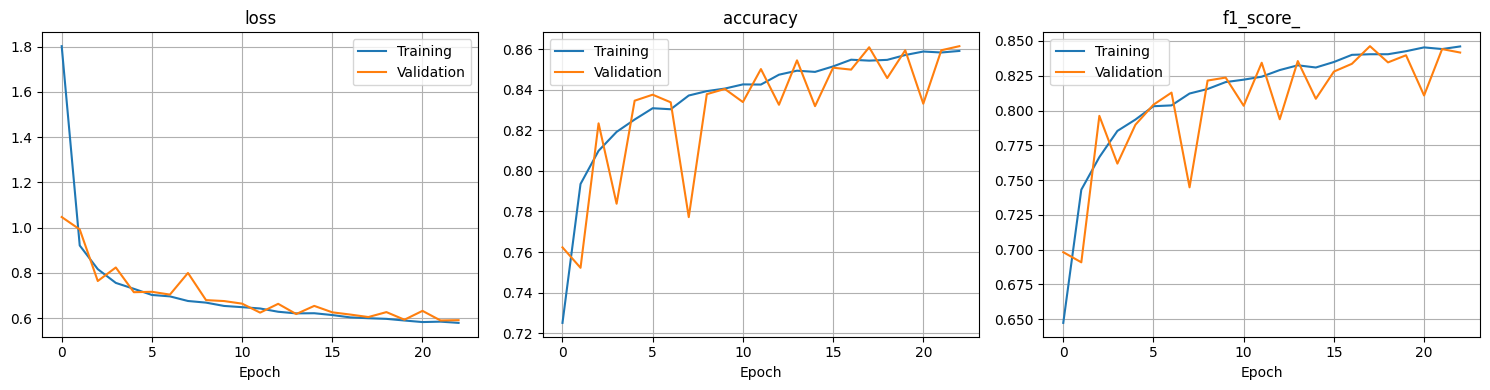

In [20]:
plot_training_history(train_l2)

In [21]:
model_fash = ks.models.Sequential(
[
    ks.layers.Input(shape=(X_train.shape[1:])),
    ks.layers.Conv2D(filters=32, kernel_size=[3,3], padding='same', activation='relu',kernel_initializer='he_normal'),
    ks.layers.MaxPooling2D(pool_size=(2, 2)),


    ks.layers.Conv2D(filters=64, kernel_size=[3,3], padding='same', activation='relu'),
    ks.layers.MaxPooling2D(pool_size=(2, 2)),

    ks.layers.Dropout(0.3),
    ks.layers.BatchNormalization(),
    ks.layers.Conv2D(filters=128, kernel_size=[3,3], padding='same', activation='relu'),
    ks.layers.Conv2D(filters=128, kernel_size=[3,3], padding='same', activation='relu'),
    ks.layers.MaxPooling2D(pool_size=(2, 2)),

    ks.layers.Dropout(0.4),
    ks.layers.Flatten(),
    ks.layers.BatchNormalization(),
    ks.layers.Dense(512, activation='relu'),

    ks.layers.Dropout(0.25),
    ks.layers.Dense(10, activation='softmax')
])

model_fash.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 64)         

In [22]:
opt = ks.optimizers.Adam(learning_rate=0.001)
early_stopping = ks.callbacks.EarlyStopping(monitor='val_f1_score_',
                               patience=10,
                              mode='max',
                               restore_best_weights=True)

model_fash.compile(optimizer=opt,
              loss=ks.losses.CategoricalCrossentropy(),
              metrics=['accuracy', f1_score_])

In [23]:
train_fash = model_fash.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=(1/8), callbacks=[early_stopping])

Epoch 1/100
407/407 [==============================] - 15s 33ms/step - loss: 0.5672 - accuracy: 0.7959 - f1_score_: 0.7804 - val_loss: 0.3666 - val_accuracy: 0.8664 - val_f1_score_: 0.8479
Epoch 2/100
407/407 [==============================] - 13s 32ms/step - loss: 0.3835 - accuracy: 0.8590 - f1_score_: 0.8518 - val_loss: 0.2933 - val_accuracy: 0.8943 - val_f1_score_: 0.8897
Epoch 3/100
407/407 [==============================] - 13s 33ms/step - loss: 0.3340 - accuracy: 0.8756 - f1_score_: 0.8703 - val_loss: 0.2584 - val_accuracy: 0.9058 - val_f1_score_: 0.9006
Epoch 4/100
407/407 [==============================] - 13s 32ms/step - loss: 0.3019 - accuracy: 0.8876 - f1_score_: 0.8820 - val_loss: 0.2621 - val_accuracy: 0.9045 - val_f1_score_: 0.8994
Epoch 5/100
407/407 [==============================] - 13s 32ms/step - loss: 0.2840 - accuracy: 0.8942 - f1_score_: 0.8891 - val_loss: 0.2401 - val_accuracy: 0.9144 - val_f1_score_: 0.9092
Epoch 6/100
407/407 [==============================] - 

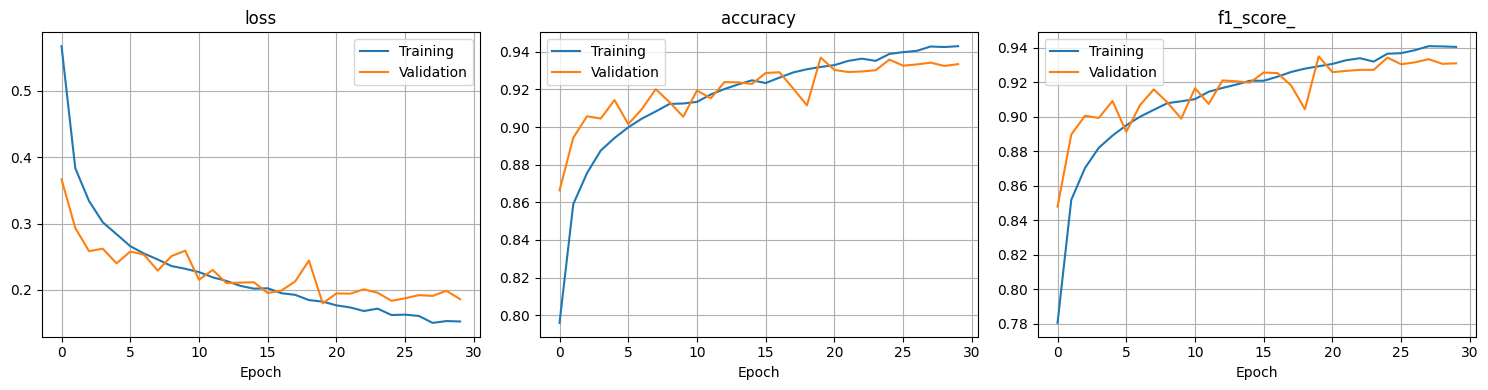

In [24]:
plot_training_history(train_fash)

## Task 2.4: Evaluate your best model on the test dataset and submit your prediction to the Kaggle leaderboard

In [25]:
Kaggle_model_prediction = model_fash.predict(X_test)
flat_Kaggle_model_prediction_prediction = np.argmax(Kaggle_model_prediction, axis=1)
submissionKaggle = pd.DataFrame()
submissionKaggle['ID'] = range(len(flat_Kaggle_model_prediction_prediction))
submissionKaggle['Prediction'] = flat_Kaggle_model_prediction_prediction
submissionKaggle.to_csv('KaggelSubmission.csv', index=False)

329/329 [==============================] - 2s 6ms/step


# Task 2.5: Fashion-MNIST Discussion

### Task 3.5.1
- Feel Free to experimant on acitecture
- Comment on the choice of layers and hyper paramters.
    - Did you find some different results in changing a hyper paramter or add/remove a layer.


Adding random noise to the input data can sometimes help the model become more robust by learning to ignore irrelevant details. However, in our case, it made things worse. This could be because the Fashion-MNIST dataset is clean, meaning noise would only make the model worse on images without clear class.

Leaky ReLU is often used to solve the "dying ReLU" problem (when ReLU units become inactive). While Leaky ReLU typically helps with more complex datasets, it may have introduced unnecessary complexity here, leading to slightly worse results.

Rotation in the data can often help with improving generalization, it seems it worsened our model's performance. This could indicate that Fashion-MNIST doesn't benefit as much from rotations because the items in the dataset (like shirts, pants, etc.) have a natural orientation, and rotating them introduces unnatural variations.

l1 and l2 regularization helps to prevent overfitting by penalizing large weights. While it succeeded in keeping our model from overfitting, the overall performance wasn't great. This could suggest that the model was limitied in the ability to capture enough complexity from the data.

Droput which is another methode for prevetnting overfitting and made the model better. This made the model not so overfitted as well as giving a high score.

Kernel size plays a critical role in feature extraction in convolutional layers. Smaller kernels may have missed some patterns, while larger ones might have been too general. Thats why 3,3 was the optimal for us.

Reducing or increasing the batch size made the model worse. Reducing bath size leads to noisier gradient updates. Larger batches could provide more overfitting.

Adding more layers made the model worse. This could be because the model got to complex, not beeing able to classify new images.

Adding batch normalization did not improve the model, performance was just a little bit worse than with dropout only. We expected batch normalization to make the model overfit less and converge faster.